# Compiling Datsets

In this notebook, we will merge cast interest and twitter data with the original dataset.

__As we have already merged the youtube sentiments and text with the original data in 04_collection_youtube_text.ipynb__,

in this notebook, we will:

1) Merging cast interest 

2) Merging twitter sentiments polarity and text

3) Perform EDA of the compiled dataset

In [198]:
import pandas as pd
import pickle
import numpy as np
import os
import json
import spacy
import re
import nltk
import string
import fasttext

## 1) Merging cast interest over time

In [199]:
# Reading average_cast_interest.csv from 02_collection_cast_interest.ipynb
df_cast_interest = pd.read_csv("average_cast_interest.csv")
del df_cast_interest['Unnamed: 0']

#reading final_df.pickle from 04_collection_youtube_text.ipynb
df = pd.read_pickle("final_df.pickle")

In [200]:
# Merging by id
final = pd.merge(df_cast_interest, df, on='id', how='inner')
final.head()

,id,average_interest,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,...,FALSE,youtube,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,youtube_text,index,youtube_polarity
0,35.0,11.783871,462538,1.380432,75000000,527068851,The Simpsons Movie,Dan Castellaneta|Julie Kavner|Nancy Cartwright...,http://www.simpsonsmovie.com/,David Silverman,...,2163203,XPG0MqIcby8,320667.0,1780.0,82.0,0,178,"[wherefun begin, season, would love see crosso...",462538,0.096988
1,155.0,17.280169,468569,8.466668,185000000,1001921825,The Dark Knight,Christian Bale|Michael Caine|Heath Ledger|Aaro...,http://thedarkknight.warnerbros.com/dvdsite/,Christopher Nolan,...,2163203,kmJLuwP3MbY,1765731.0,5122.0,625.0,0,239,"[whos afterbatman teaser, time favorite movie ...",468569,0.203129
2,189.0,22.449612,458481,1.840817,65000000,39407616,Sin City: A Dame to Kill For,Mickey Rourke|Jessica Alba|Josh Brolin|Joseph ...,http://sincity-2.com/,Frank Miller|Robert Rodriguez,...,2163203,WvAvEcxwglI,962513.0,1867.0,121.0,0,160,"[00happy face smiley6, look like christms, don...",458481,0.115319
3,257.0,21.886667,380599,0.826568,50000000,42093706,Oliver Twist,Barney Clark|Ben Kingsley|Jamie Foreman|Harry ...,http://www.olivertwistthemovie.co.uk/,Roman Polanski,...,2163203,4aUGLJicck8,485985.0,1019.0,74.0,0,87,"[movie really like well mannered, 144p meet, g...",380599,0.256456
4,285.0,21.082955,449088,4.965391,300000000,961000000,Pirates of the Caribbean: At World's End,Johnny Depp|Orlando Bloom|Keira Knightley|Geof...,http://disney.go.com/disneypictures/pirates/,Gore Verbinski,...,2163203,HKSZtp_OGHY,1781621.0,7963.0,137.0,0,651,"[ed, still remember epic trailer need potc6 sa...",449088,0.149938


## 2) Merging twitter sentiments and text

### Merging Twitter Sentiments

In [201]:
# reading sentiments polarity from sentimental.csv from 03_collection_twitter_text.ipynb
twitter = pd.read_csv("sentimental.csv")

# basic cleaning before merging
twitter["imdb_id_x"] = twitter["tmdb_id"].apply(lambda x: x[2:])
twitter = twitter[1:]
twitter["imdb_id_x"] = twitter["imdb_id_x"].astype(int)
twitter.rename(columns = {'polarity':'twitter_polarity'}, inplace = True) 
twitter.rename(columns = {'imdb_id_x':'imdb_id'}, inplace = True) 
twitter = twitter.drop(columns = ["tmdb_id"])
twitter.head()

,twitter_polarity,imdb_id
1,0.092365,69281
2,0.081299,120604
3,0.054143,120855
4,0.135419,145503
5,0.122194,155711


In [202]:
# Merging by imdb_id
final = pd.merge(final, twitter, on='imdb_id')

In [203]:
# Preview of dataset 
final.head()

,id,average_interest,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,...,youtube,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,youtube_text,index,youtube_polarity,twitter_polarity
0,35.0,11.783871,462538,1.380432,75000000,527068851,The Simpsons Movie,Dan Castellaneta|Julie Kavner|Nancy Cartwright...,http://www.simpsonsmovie.com/,David Silverman,...,XPG0MqIcby8,320667.0,1780.0,82.0,0,178,"[wherefun begin, season, would love see crosso...",462538,0.096988,0.066098
1,155.0,17.280169,468569,8.466668,185000000,1001921825,The Dark Knight,Christian Bale|Michael Caine|Heath Ledger|Aaro...,http://thedarkknight.warnerbros.com/dvdsite/,Christopher Nolan,...,kmJLuwP3MbY,1765731.0,5122.0,625.0,0,239,"[whos afterbatman teaser, time favorite movie ...",468569,0.203129,0.099834
2,189.0,22.449612,458481,1.840817,65000000,39407616,Sin City: A Dame to Kill For,Mickey Rourke|Jessica Alba|Josh Brolin|Joseph ...,http://sincity-2.com/,Frank Miller|Robert Rodriguez,...,WvAvEcxwglI,962513.0,1867.0,121.0,0,160,"[00happy face smiley6, look like christms, don...",458481,0.115319,0.044260
3,257.0,21.886667,380599,0.826568,50000000,42093706,Oliver Twist,Barney Clark|Ben Kingsley|Jamie Foreman|Harry ...,http://www.olivertwistthemovie.co.uk/,Roman Polanski,...,4aUGLJicck8,485985.0,1019.0,74.0,0,87,"[movie really like well mannered, 144p meet, g...",380599,0.256456,0.099671
4,285.0,21.082955,449088,4.965391,300000000,961000000,Pirates of the Caribbean: At World's End,Johnny Depp|Orlando Bloom|Keira Knightley|Geof...,http://disney.go.com/disneypictures/pirates/,Gore Verbinski,...,HKSZtp_OGHY,1781621.0,7963.0,137.0,0,651,"[ed, still remember epic trailer need potc6 sa...",449088,0.149938,0.141292


### Merging Twitter Text

In [204]:
# reading twitter texts from combined_pp.csv from 03_collection_twitter_text.ipynb
twitter_text =  pd.read_csv('combined_pp.csv')

/Users/mingwei/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [206]:
# basic cleaning before merging
twitter_text =  pd.read_csv('combined_pp.csv')
twitter_text = twitter_text[twitter_text["tmdb_id"].isnull() == False]
twitter_text = twitter_text[twitter_text["tmdb_id"] != "tmdb_id"]
twitter_text["tmdb_id"] = twitter_text["tmdb_id"].astype(str).apply(lambda x: x[2:])
twitter_text["imdb_id_x"] = twitter_text["tmdb_id"]
twitter_text.rename(columns = {'imdb_id_x':'imdb_id'}, inplace = True) 
twitter_text.head()

,tmdb_id,Movie_Title,Tweet_Content,cleaned_2,polarity,subjectivity,sentiment,imdb_id
0,0369610,Jurassic World,Just doing the Math...and looming at estimates...,mathand looming estimate online keep running w...,0.25,0.333333,pos,0369610
1,0369610,Jurassic World,#lego #jurassicworld #fullhouse complete serie...,lego fullhouse complete series mowgli make for…,0.1,0.4,pos,0369610
2,0369610,Jurassic World,I liked a @YouTube video http://youtu.be/UxXZe...,liked youtube video aquatic update trailer gam...,0.1,0.6,pos,0369610
3,0369610,Jurassic World,I'm earning #mPLUSRewards in Jurassic World: T...,earning mplusrewards game,-0.4,0.4,neg,0369610
4,0369610,Jurassic World,"@DanFerrariLane Armageddon, Jurassic World, th...",danferrarilane armageddon newer star trek uhh ...,0,0,neg,0369610


In [207]:
twitter_ids = twitter_text["imdb_id"].unique()
tweetArr = []
for i in twitter_ids:
    temp_arr = []
    temp = twitter_text[twitter_text["imdb_id"] == i]
    for row, col in temp.iterrows():
        temp_arr.append(col["cleaned_2"])
    tweetArr.append(temp_arr)

In [208]:
twitter_final = pd.DataFrame(twitter_ids, columns = ["imdb_id"])

In [209]:
twitter_final.head()

,imdb_id
0,0369610
1,1392190
2,2908446
3,2488496
4,2820852


In [210]:
twitter_final = pd.DataFrame(twitter_ids, columns = ["imdb_id"])
twitter_final["twitter_text"] = tweetArr
twitter_final["imdb_id"] = twitter_final["imdb_id"].astype(int)

In [211]:
# Merging 
final = pd.merge(twitter_final, final, on = "imdb_id")

In [212]:
final["twitter_text"]

0       [mathand looming estimate online keep running ...
1       [liked youtube video max ost brother arm junki...
2       [boerneaj want know kind soil fertile lack civ...
3       [monday meme war noguilt life noguilt life, le...
4       [wiz khalifa see ft charlie puth official vide...
                              ...                        
3231    [radiowien jack flash von rolling stone, got h...
3232    [need technology make drawing dirt window car,...
3233    [hate one ever want bored work house oh well, ...
3234    [bender isnt bad people hinted best futurama t...
3235    [walk nice air conditioned theater see, video ...
Name: twitter_text, Length: 3236, dtype: object

In [183]:
final.to_pickle("final.pickle")

## 3) Inspection of the Compiled Dataset

We will perform plot graphs to compare: 

1) distribution of youtube polarity, twitter polarity and cast interests

2)  youtube polarity, twitter polarity and cast interests against vote_average

In [217]:
import plotly.graph_objs as go
import chart_studio.plotly
import cufflinks
from plotly.offline import iplot
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff

pd.options.display.max_columns = 30
InteractiveShell.ast_node_interactivity = 'all'
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

### Youtube data

In [218]:
# Distribution of youtube polarity 
model['youtube_polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution for Youtube')

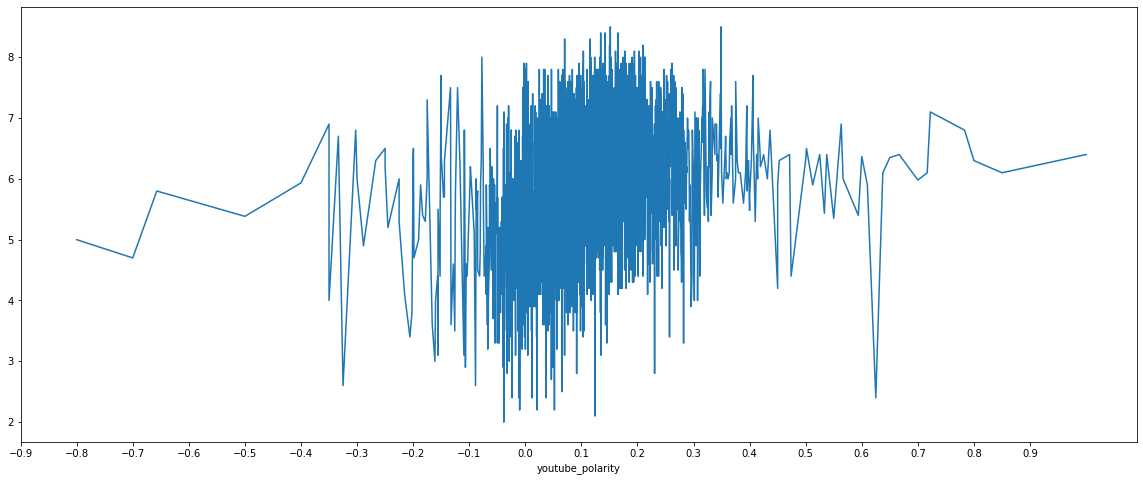

In [245]:
# Comparing youtube polarity against vote_average
model.groupby('youtube_polarity')['vote_average'].mean().plot(figsize = (20,8),xticks=np.arange(-0.9,1,0.10))

## Twitter data

In [219]:
# Distribution of twitter polarity 
model['twitter_polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution for Twitter')

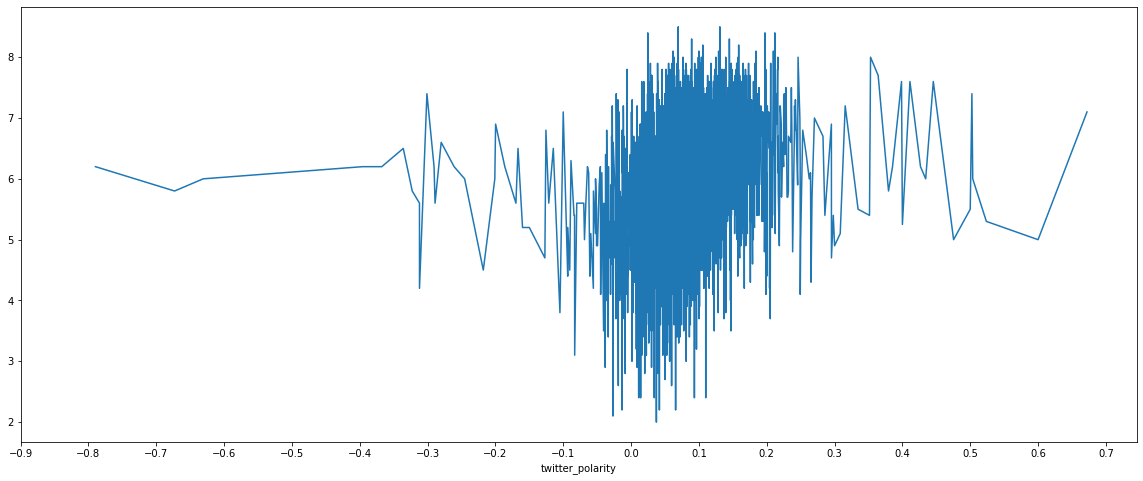

In [243]:
# Comparing youtube polarity against vote_average
model.groupby('twitter_polarity')['vote_average'].mean().plot(figsize = (20,8),xticks=np.arange(-0.9,0.80,0.1))

## Cast interest

In [226]:
# Distribution of cast interest
model['average_interest'].iplot(
    kind='hist',
    bins=50,
    xTitle='cast interest',
    linecolor='black',
    yTitle='count',
    title='Cast Interest Distribution')

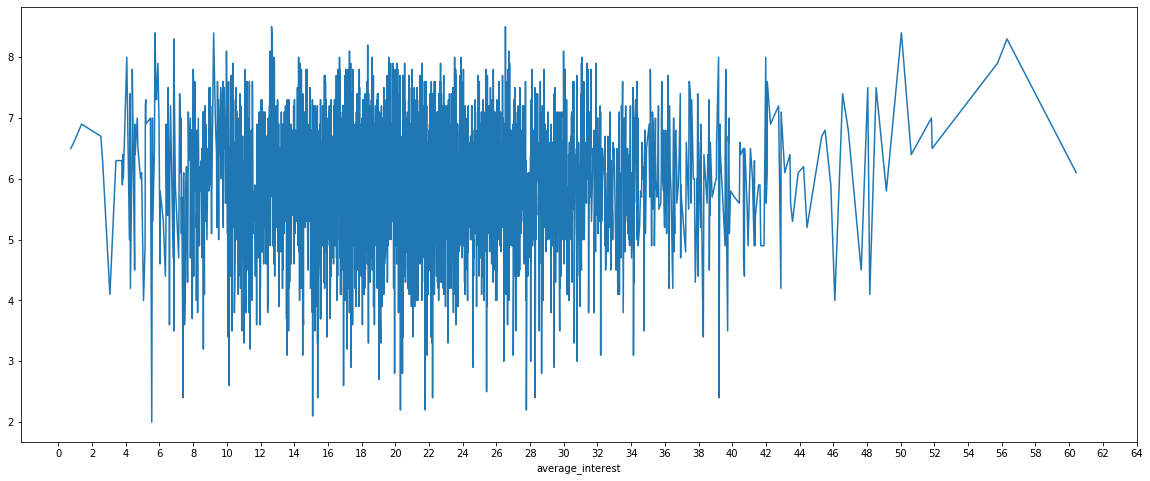

In [246]:
# cast interest against vote average
model.groupby('average_interest')['vote_average'].mean().plot(figsize = (20,8),xticks=np.arange(0,65,2))